In [37]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from scipy.optimize import fsolve
from graph import *
from tqdm import tqdm

# SBM NetworkX Visualization

docs by names (62, 108) 108
docs by names (111, 108) 108


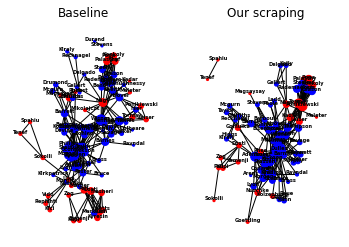

<Figure size 432x288 with 0 Axes>

Intersection, length:  166
ponikiewski->thompson
jackson->morgan
leason->rademaekers
kennan->thompson
barnes->ravndal
griffiths->mcgurn
conant->stassen
spahiu->tenef
koch->steele
barnes->kennan
smith->wisner
palasthy->rademaekers
barbour->barrett
phillips->stassen
savage->thompson
dulles->meyer
kennan->wisner
savage->wisner
leiser->tormay
mathews->smith
adenauer->stassen
bross->jackson
dosti->ermenji
barbour->kohler
bohlen->joyce
dulles->eisenhower
hier->thompson
mathews->reinhardt
graf->konkoly
dulles->jackson
poole->wisner
kupi->zog
graf->leason
dosti->kupi
palasthy->popa
konkoly->steele
stassen->stein
joyce->reinhardt
bohlen->dulles
conant->smith
jackson->stassen
bruce->smith
morgan->stassen
adenauer->jackson
leason->popa
hoover->ladd
pali->sokolli
ermenji->zog
hoover->wisner
dulles->morner
morner->murphy
barnes->savage
bross->dulles
jackson->phillips
barnes->thompson
conant->jackson
kyes->phillips
dulles->kohler
thompson->tormay
hier->ponikiewski
hier->leiser
dulles->joyce
phillips

In [38]:
# build network from adjacency matrix

# %load graph.py
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sys

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
np.set_printoptions(threshold=sys.maxsize)

def getfreqmatrix(filename):
    df = pd.read_csv(filename)
    names = list(df.columns)[1:]
    rownames = list(df["id"])  
    mydata = genfromtxt(filename, delimiter=',')
    mydata = mydata[1:,1:]
    return (names, rownames, mydata)


# M is a frequency matrix rows=documents, columns=names
def make_adjacency_matrix(M, names):
    n = len(names)
    print("docs by names", M.shape, n)
    A = np.zeros(n * n).reshape((n,n))
    for doc in M:
        for i in range(n):
            if doc[i] != 0:
                for j in range(i+1, len(doc)):
                    if doc[j] != 0:
                        A[i][j] += 1
                        A[j][i] += 1
    return A

# graph from adjacency matrix names by names
def nx_graph_from_adjacency_matrix(M, names, df, fig):
    V = names

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(V, nodetype="green")

    # Find the non-zero indices in the biadjacency matrix to connect those nodes
    G.add_edges_from([ (V[i], V[j]) for i, j in zip(*M.nonzero()) ])
    
    # formatting
    # pos = nx.random_layout(G, seed=490)
    pos = nx.spring_layout(G, seed=101, k=0.3, iterations=35)
    # remove isolated nodes
    
    ### This code removes nodes that are not connected
    #deg = G.degree()
    #to_remove = [n[0] for n in deg if n[1] == 0]
    #G.remove_nodes_from(to_remove)

    #colors = [float(G.degree(n)) for n in G]
    sizes = [float(G.degree(n))*5 for n in G] 
    labels = {}
    for n in G.nodes():
        if G.degree(n) > 0:
            s = n[0].upper() + n[1:]
            labels[n] = s

    colors = []
    for n in G:
        r = df.loc[df["lastname"].str.lower() == n]
        if r.iloc[0]['affiliation'] == "west":
            colors.append("blue")
        elif r.iloc[0]['affiliation'] == "east":
            colors.append("red")
        else:
            colors.append("grey")
        pass

    nx.draw(G, pos=pos, node_color=colors, node_size=sizes, with_labels=False)
    nx.draw_networkx_labels(G, pos, labels, font_size=5, 
            font_weight="bold", verticalalignment="bottom")
    f = plt.figure(fig)
    return (G, f)

# Adjust appearance of the nodes, edges, labels, etc.
def adjust_appearance_bipartite(G, pos):
    # Shift labels up off of their node
    textPos = pos.copy()
    for k in textPos:
        textPos[k][1] += .01

    labels = {}    
    for n in G.nodes():
        # Dont label documents, and only label figures with
        # a decently high degree 
        if ".txt" not in n and G.degree(n) > 2:
            s = n[0].upper() + n[1:]
            labels[n] = s
    nx.draw_networkx_labels(G, textPos, labels, font_size=10,  font_weight="bold",
                            verticalalignment="bottom")


# makes bipartite graph from documents to people
def nx_graph_from_biadjacency_matrix(M, txtfiles, names):

    U = txtfiles
    V = names

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(U, bipartite=0, nodetype="doc", nodesize=200, nodelabel=False)
    G.add_nodes_from(V, bipartite=1, nodetype="person", nodesize=50, nodelabel=True)

    # Find the non-zero indices in the biadjacency matrix to connect those nodes
    G.add_edges_from([ (U[i], V[j]) for i, j in zip(*M.nonzero()) ])
    
    # remove isolated nodes
    deg = G.degree()
    to_remove = [n[0] for n in deg if n[1] == 0]
    G.remove_nodes_from(to_remove)

    # Sets the colors of the nodes
    types= G.nodes(data="nodetype")
    print(types)
    colors = []
    for elm in types:
        print(elm)
        (n, typ) = elm
        degree = G.degree(n)
        if typ == "person":
            colors.append(float(degree))
        else:
            colors.append(-10.0)
    
    # formatting
    #colors = [float(G.degree(n)) for n in G]
    sizes = [u[1] for u in G.nodes(data="nodesize")]
    pos = nx.spring_layout(G, seed=101, k=0.1, iterations=15)
    nx.draw(G, pos=pos, node_size = sizes, with_labels=False, node_color = colors, edgecolors='black')

    adjust_appearance_bipartite(G, pos)

    plt.show()
    return G


# given set of edges, print them nicely
def format_edges(edges):
    for edge in list(edges):
        (n1, n2) = edge
        print(n1 + "->" + n2)

# given two graphs, returns jaccard index
def get_jaccard_index(G, H):
    A = set(G.edges)
    B = set(H.edges)
    n11 = A.intersection(B)   
    n10 = A.difference(B)
    n01 = B.difference(A)
    print("Intersection, length: ", len(n11))
    format_edges(n11)
    print("\n In our graph, not in baseline, length:", len(n10))
    format_edges(n10)
    print("\n In baseline, not in our Graph, length:", len(n01))
    format_edges(n01)
    return len(n11) / (len(n11) + len(n01) + len(n10))

def get_scraped_graph():
    namesdf = pd.read_csv("names.csv")
    (names, ids, basedata) = getfreqmatrix("baseline/baseline_frequency.csv")
    basemat = make_adjacency_matrix(basedata, names)
    (baseG, basef) = nx_graph_from_adjacency_matrix(basemat, names, namesdf, 2)
    return (baseG, basef)

if __name__ == "__main__":
    namesdf = pd.read_csv("names.csv")

    plt.subplot(1, 2, 1)
    (names, ids, basedata) = getfreqmatrix("baseline/baseline_frequency.csv")
    basemat = make_adjacency_matrix(basedata, names)
    (baseG, basef) = nx_graph_from_adjacency_matrix(basemat, names, namesdf, 1)
    plt.title('Baseline')
    

    plt.subplot(1, 2, 2)
    plt.title('Our scraping')
    (names, txtfiles, mydata) = getfreqmatrix("frequency.csv")  
    A = make_adjacency_matrix(mydata, names)
    (G, f1) = nx_graph_from_adjacency_matrix(A, names, namesdf, 2)
    # nx_graph_from_biadjacency_matrix(mydata, txtfiles, names)

    plt.show()

    J = get_jaccard_index(G, baseG)
    print("Jaccard index: ", J)

In [39]:
# map groups (clusters from SBM from R output) to colors in the network
# arrange clusters in a circular formation with Dulles in the center

G = baseG

color_map = []
# groups = [3,7,6,6,2,6,4,6,6,6,6,6,2,3,2,7,7,6,7,5,6,1,7,3,5,6,5,7,7,6,5,6,6,6,4,4,3,2,7,7,7,7,2,5,7,7,6,7,6,7,5,5,5,3,5,4,4,4,6,7,7,5,6,6,7,6,7,3,6,6,7,6,7,7,5,5,3,4,4,5,5,7,7,6,7,6,7,7,2,4,3,7,7,3,5,3,7,7,7,2,4,7,7,7,7,6,2,5]
groups = [1,6,6,6,2,6,4,6,6,6,6,1,6,2,6,6,6,6,5,6,1,6,1,5,6,5,6,6,6,6,3,6,4,6,4,1,2,6,6,6,6,2,5,6,6,6,6,6,6,3,5,5,1,5,4,4,3,4,6,6,6,6,5,6,6,6,6,6,1,6,6,6,6,1,6,3,5,1,4,4,3,3,6,6,6,6,6,6,6,2,4,1,6,6,1,3,1,6,6,6,2,4,6,6,6,6,2,5]
pos = nx.circular_layout(G)
cluster_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
angs = np.linspace(0, 2*np.pi, len(cluster_colors))
repos = []
rad = 3
repos.append(np.array([0, 0]))
for ea in angs:
        print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
        
df = namesdf        
colors = []
for n in baseG:
    r = df.loc[df["lastname"].str.lower() == n]
    if r.iloc[0]['affiliation'] == "west":
        colors.append("blue")
    elif r.iloc[0]['affiliation'] == "east":
        colors.append("red")
    else:
        colors.append("grey")

for i in range(len(groups)):
    group = groups[i]
    name = names[i]
    if name not in list(nx.isolates(G)):
        if group == 1:
            color = 'red'
            color_map.append('red')
            posx = 0
        elif group == 2:
            color = 'orange'
            color_map.append('orange')
            posx = 1
        elif group == 3:
            color = 'yellow'
            color_map.append('yellow')
            posx = 2
        elif group == 4:
            color = 'green'
            color_map.append('green')
            posx = 3
        elif group == 5:
            color = 'blue'
            color_map.append('blue')
            posx = 4
        elif group == 6:
            color = 'purple'
            color_map.append('purple')
            posx = 5
            '''
        elif group == 7:
            color = 'pink'
            color_map.append('pink') 
            posx = 6
        '''
        pos[name] += repos[posx]



    G.nodes()[name]['nodetype'] = color
    G.nodes()[name]['fillcolor'] = colors[i]
    G.nodes()[name]['style']='filled'
    
    
G.remove_nodes_from(list(nx.isolates(G)))

# --- End_myhack ---

3.0 0.0
0.9270509831248424 2.8531695488854605
-2.427050983124842 1.7633557568774196
-2.4270509831248424 -1.7633557568774192
0.9270509831248417 -2.853169548885461
3.0 -7.347880794884119e-16


In [40]:
list(nx.isolates(G))

[]

In [50]:
for n in G:
    print(n)

adenauer
aschan
barbour
barnes
barrett
behoff
bohlen
bross
bruce
conant
davies
delgado
devine
dolbeare
dosti
drumond
dulles
durand
eisenhower
ermenji
foster
fresheri
gellert
gomulka
graf
griffiths
hier
hoover
jackson
joyce
juhast
kadar
kennan
ketts
kici
kiraly
kirkpatrick
koch
kohler
konkoly
kuni
kupi
kyes
kyresin
ladd
lawrence
leason
leiser
lyon
magsaysay
maleter
markham
mathews
mcgurn
meeker
meyer
mikolajczk
morgan
morner
murphy
nagy
nuschke
oconnor
oshanughnessy
palasthy
pali
phillips
ponikiewski
poole
popa
rademaekers
ravndal
recknagel
reinhardt
repishti
rhee
savage
sheltt
smith
sokolli
spahiu
stassen
steele
stein
stevens
tenef
thompson
tormay
ujka
vido
wailes
wisner
zog


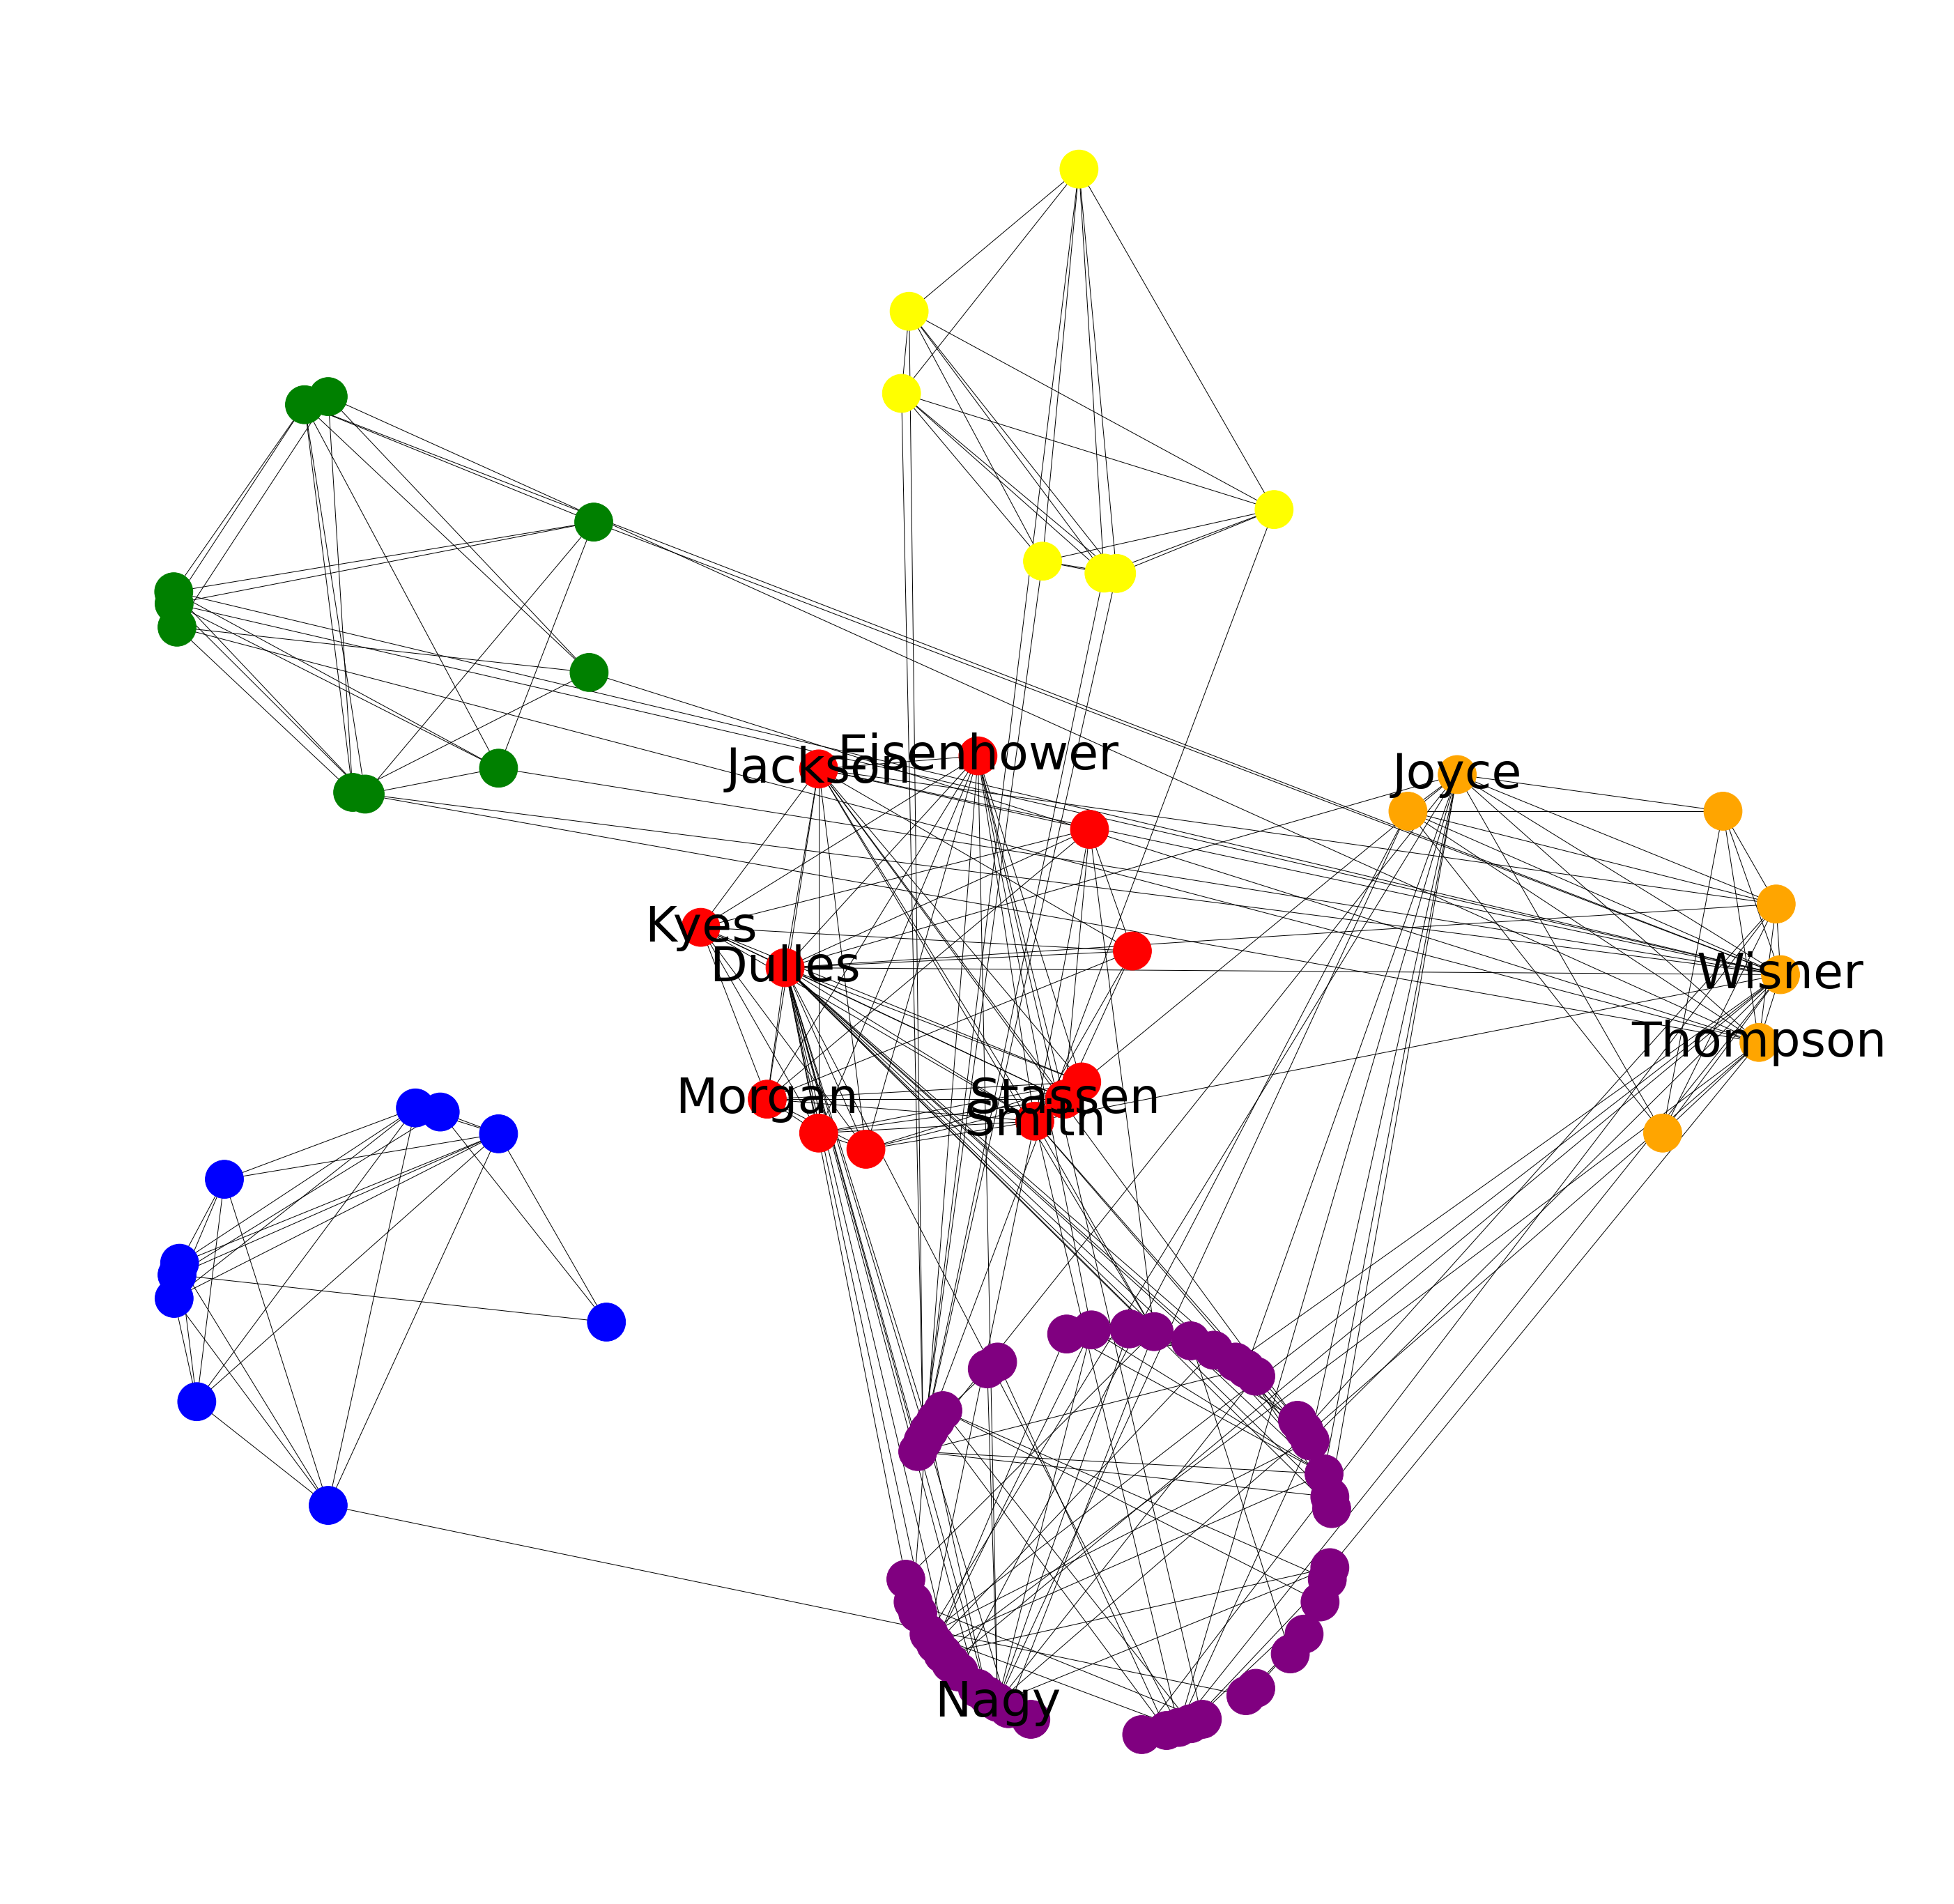

In [49]:
pos["dulles"] -=0.5
labels = {}
for n in G.nodes():
    if G.degree(n) > 10:
        s = n[0].upper() + n[1:]
        labels[n] = s

fig, ax = plt.subplots(figsize=(50,50))           
nx.draw(G, node_color=color_map, node_size=3000, font_size=70, pos=pos, with_labels=True, labels=labels)
plt.show()

In [113]:
dl = list(nx.neighbors(G, "dulles"))
dl.append("dulles")
print(dl)

['adenauer', 'aschan', 'barbour', 'barnes', 'barrett', 'bohlen', 'bross', 'conant', 'devine', 'eisenhower', 'foster', 'jackson', 'joyce', 'kirkpatrick', 'kohler', 'kyes', 'lyon', 'mathews', 'meyer', 'morgan', 'morner', 'murphy', 'nuschke', 'oconnor', 'phillips', 'reinhardt', 'smith', 'stassen', 'stein', 'wisner', 'dulles']


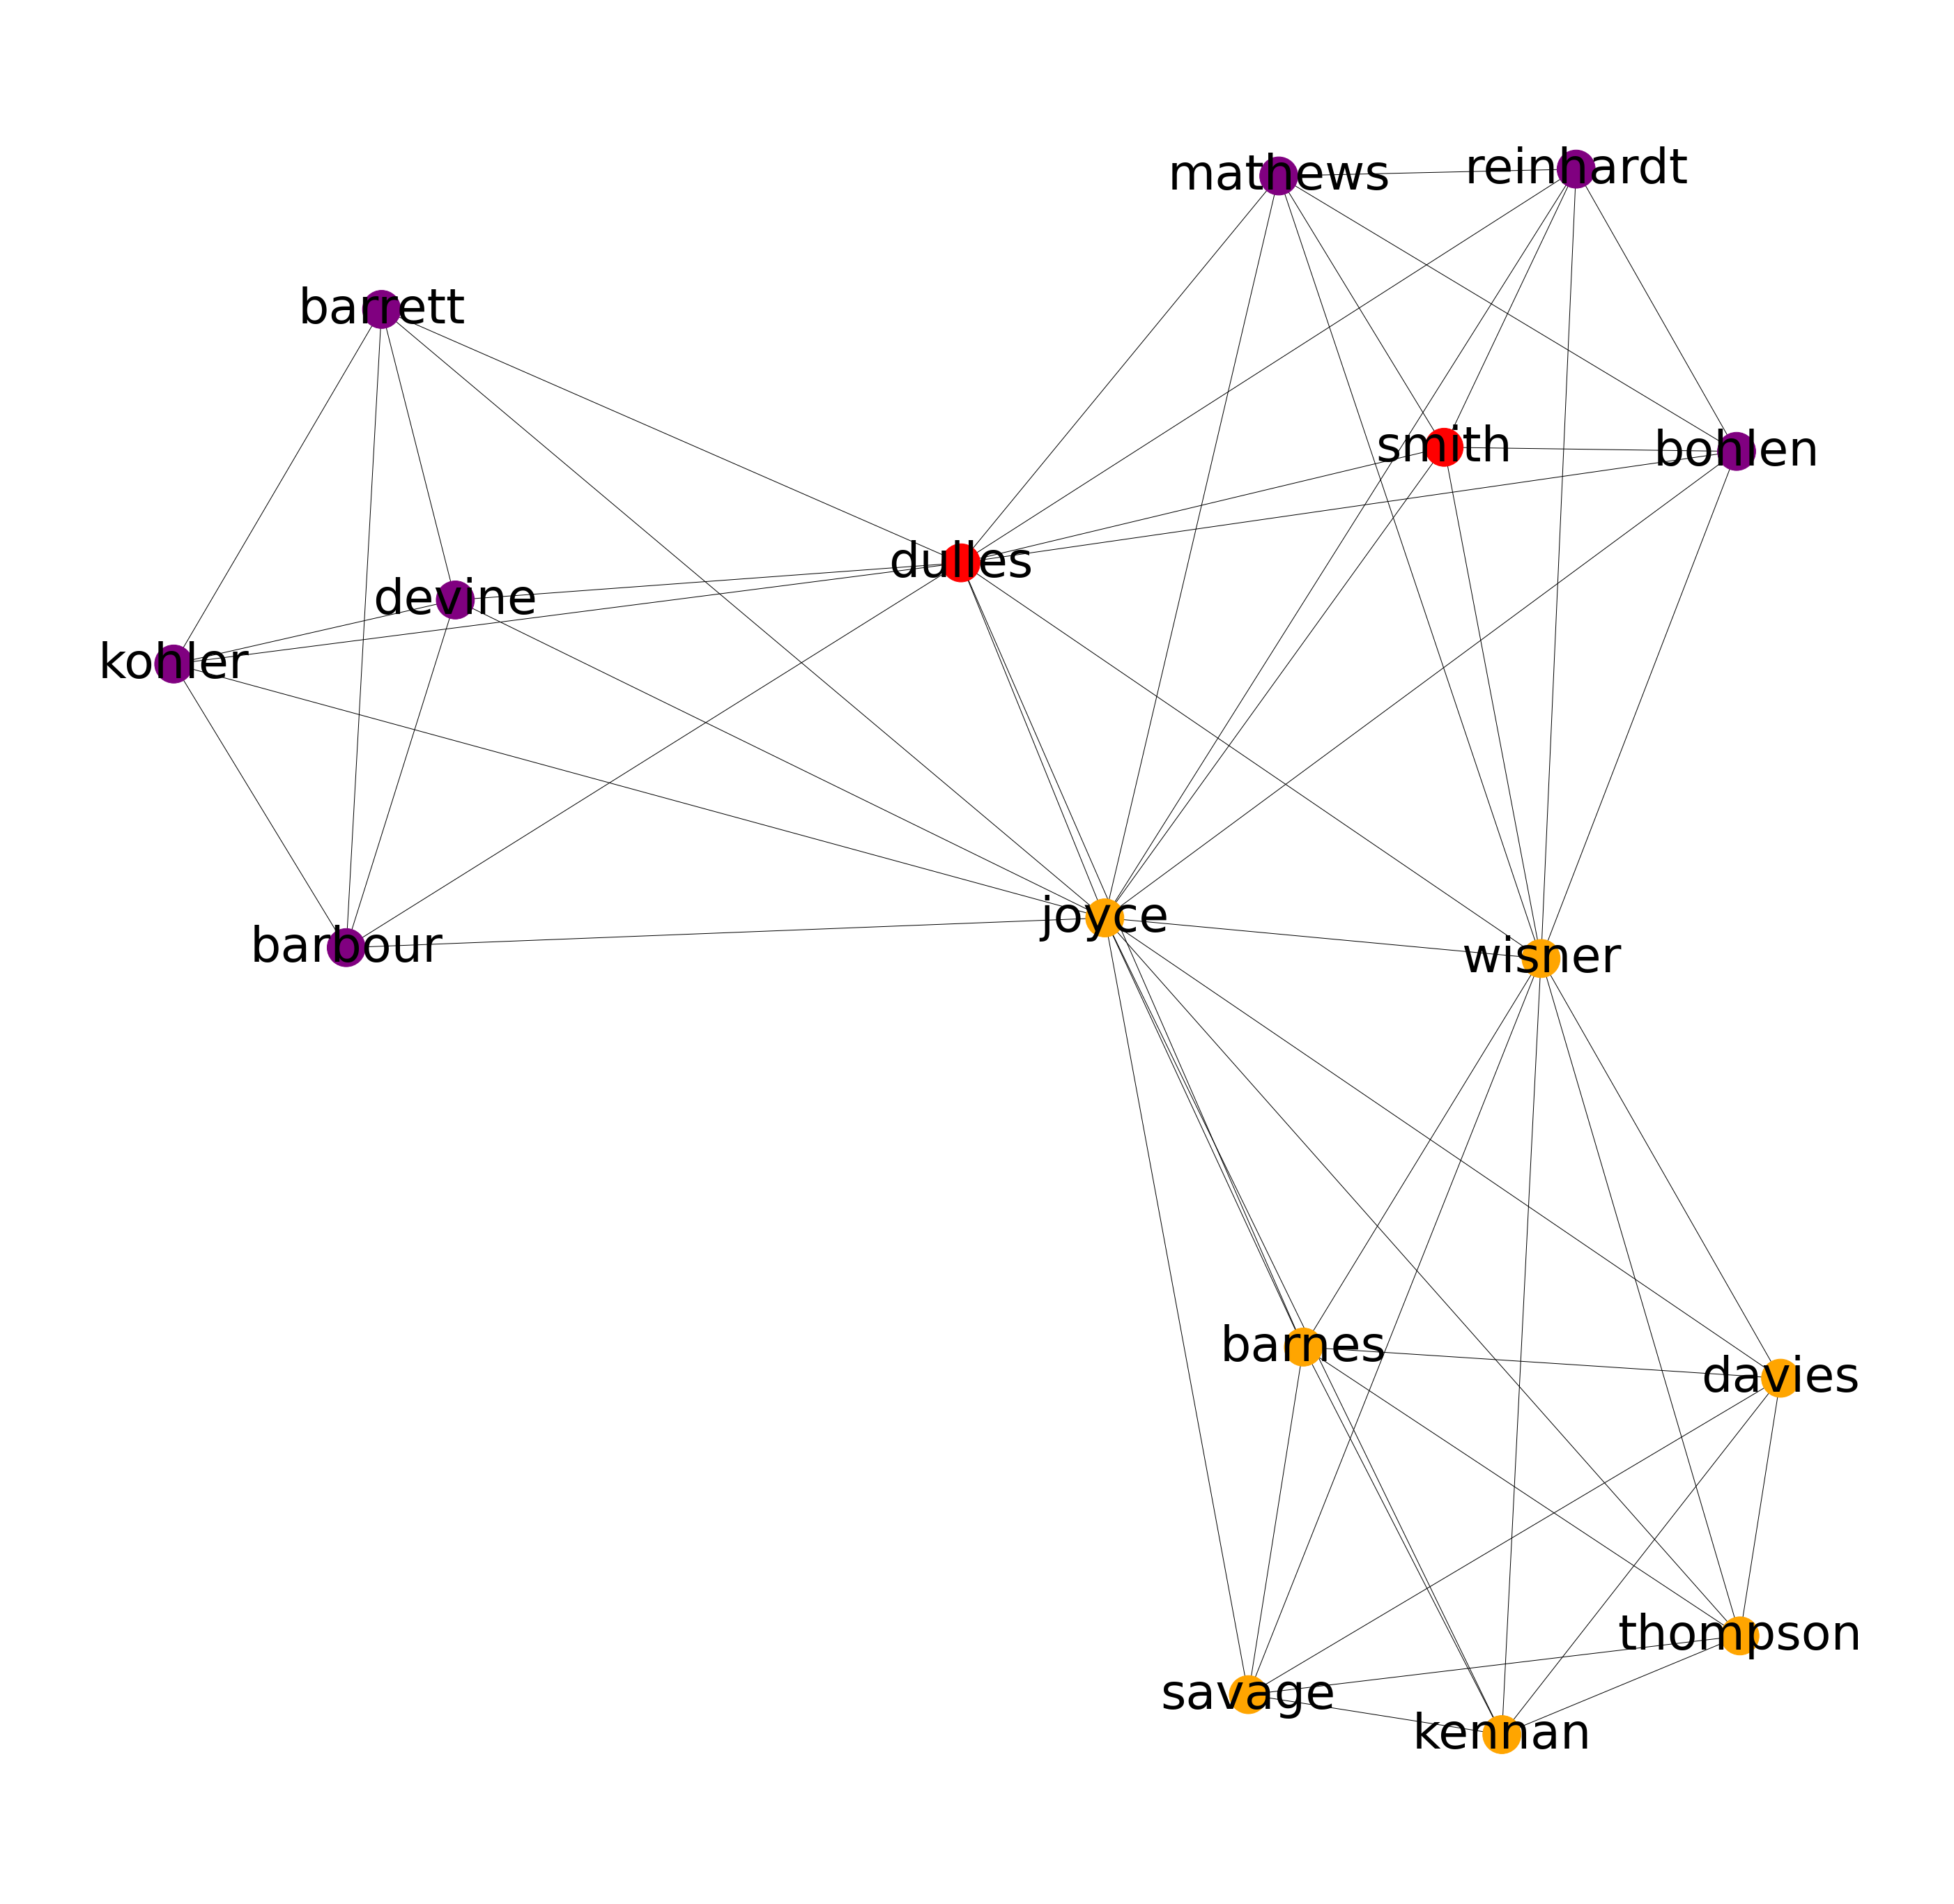

In [119]:
namedict = {}
for i in range(len(groups)):
    namedict[names[i]] = groups[i]

neighbors = list(nx.neighbors(G, "joyce"))
neighbors.append("joyce")
newG = G.subgraph(neighbors)

    
new_color_map = []
for n in newG:
    group = namedict[n]
    if group == 1:
        new_color_map.append('red')
    elif group == 2:
        new_color_map.append('orange')
    elif group == 3:
        new_color_map.append('yellow')
    elif group == 4:
        new_color_map.append('green')
    elif group == 5:
        new_color_map.append('blue')
    elif group == 6:
        new_color_map.append('purple')




        
fig, ax = plt.subplots(figsize=(50,50))
nx.draw(newG, node_color=new_color_map, node_size=3000, font_size=70, with_labels=True)
plt.show()

In [116]:
print(new_color_map)
print(newG.nodes)

['purple', 'purple', 'red', 'purple', 'red', 'red', 'purple', 'purple', 'red', 'purple', 'red', 'purple', 'purple', 'purple', 'purple', 'orange', 'red', 'red', 'red', 'purple', 'purple', 'purple', 'orange', 'purple', 'orange', 'red', 'red', 'purple', 'purple', 'red', 'red']
['bohlen', 'barrett', 'phillips', 'mathews', 'conant', 'jackson', 'foster', 'devine', 'adenauer', 'bross', 'stein', 'kohler', 'kirkpatrick', 'lyon', 'morner', 'joyce', 'smith', 'eisenhower', 'stassen', 'murphy', 'aschan', 'reinhardt', 'wisner', 'nuschke', 'barnes', 'kyes', 'morgan', 'meyer', 'barbour', 'dulles', 'oconnor']


In [81]:
print(newnames)
print(new_color_map)

['adenauer', 'aschan', 'barbour', 'barnes', 'barrett', 'bohlen', 'bross', 'conant', 'devine', 'eisenhower', 'foster', 'jackson', 'joyce', 'kirkpatrick', 'kohler', 'kyes', 'lyon', 'mathews', 'meyer', 'morgan', 'morner', 'murphy', 'nuschke', 'oconnor', 'phillips', 'reinhardt', 'smith', 'stassen', 'stein', 'wisner']
['red', 'purple', 'purple', 'orange', 'purple', 'purple', 'purple', 'red', 'purple', 'red', 'purple', 'red', 'orange', 'purple', 'purple', 'red', 'purple', 'purple', 'purple', 'red', 'purple', 'purple', 'purple', 'red', 'red', 'purple', 'red', 'red', 'red', 'orange']


In [ ]:
# plot colored network with circular layout


fig, ax = plt.subplots(figsize=(50,50))
nx.draw(G, node_color=color_map, node_size=3000, font_size=70, pos=pos, with_labels=labels)
plt.show()

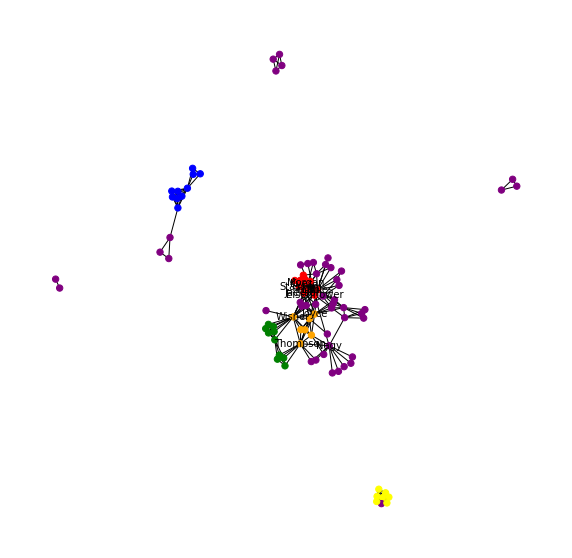

In [43]:
# plot colored network with original layout
fig, ax = plt.subplots(figsize=(10,10))
#pos = nx.spring_layout(G)
nx.draw(G, node_color=color_map, node_size=40, font_size=10, with_labels=True, labels=labels)
plt.show()

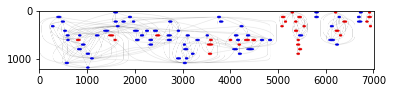

In [44]:
# Visualize graphs with pygraphviz

#pip install graphviz
#pip install pygraphviz

import pygraphviz


# G = baseG
A = nx.nx_agraph.to_agraph(G)
A.node_attr['style']='filled'
A.write('colors.dot')
A.layout('dot')
A.draw('colors.png')

import matplotlib.image as mpimg
img = mpimg.imread('colors.png')
plt.imshow(img)
plt.show()

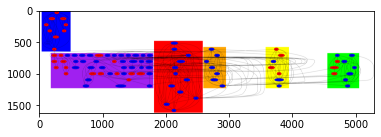

In [45]:
# Create colored subgraphs based on cluster

'''
sources:
https://stackoverflow.com/questions/40266604/pip-install-pygraphviz-fails-failed-building-wheel-for-pygraphviz
https://stackoverflow.com/questions/19674316/grouping-nodes-with-the-same-color-near-each-other-in-graphviz
https://stackoverflow.com/questions/58518554/attributeerror-graph-object-has-no-attribute-node 

https://stackoverflow.com/questions/27760956/setting-colour-of-nodes-in-pygraphviz
https://stackoverflow.com/questions/13517614/draw-different-color-for-nodes-in-networkx-based-on-their-node-value
https://stackoverflow.com/questions/19674316/grouping-nodes-with-the-same-color-near-each-other-in-graphviz
'''

# G = baseG

A = nx.nx_agraph.to_agraph(G)
A.node_attr['style']='filled'

red_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='red']
orange_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='orange']
yellow_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='yellow']
green_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='green']
blue_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='blue']
purple_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='purple']
# pink_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='pink']
A.add_subgraph(red_nodes, name = 'cluster1', color='red', style='filled')
A.add_subgraph(orange_nodes, name = 'cluster2', color='orange', style='filled')
A.add_subgraph(yellow_nodes, name = 'cluster3', color='yellow', style='filled')
A.add_subgraph(green_nodes, name = 'cluster4', color='green', style='filled')
A.add_subgraph(blue_nodes, name = 'cluster5', color='blue', style='filled')
A.add_subgraph(purple_nodes, name = 'cluster6', color='purple', style='filled')
# A.add_subgraph(pink_nodes, name = 'cluster7', color='pink', style='filled')



A.write('colors.dot')
A.layout('dot')
A.draw('clustered-colors.png')

import matplotlib.image as mpimg
img = mpimg.imread('clustered-colors.png')
plt.imshow(img)
plt.show()

# sanity check

# G.nodes()['dulles']
# A.get_node('dulles').attr['fillcolor']
# for n,d in G.nodes.items(): print(d.get('nodetype'))

# Covariate Visualization

In [46]:
namesdf

,firstname,lastname,affiliation,job,organization,private(Y/N),media(Y/N),DC(Y/N),hierarchy,additional info,Unnamed: 10
0,Konrad,Adenauer,west,Chancellor of West Germany,NaN,N,N,N,NaN,NaN,NaN
1,Richard,Arens,west,Congressional Staffer,NaN,N,N,Y,NaN,Served in at least the Immigration Subcom. of ...,feel free to add more names and information
2,Robert A.,Aschan,west,NaN,NaN,NaN,NaN,NaN,NaN,NaN,and please correct mistakes
3,Walworth,Barbour,west,Director of Eastern European Affairs,STATE,N,N,Y,3.0,Also STATE and FS later in life,NaN
4,Nathan Spencer,Barnes,west,Chief of Eastern Affairs Division in the Berli...,HICOG,N,N,N,4.0,"Variously signs his name ""Spencer Barnes"" and ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...
109,Fritz Willi Karl,Goettling,east,German National Accused of being American CIC ...,NaN,Y,N,N,NaN,NaN,NaN
110,Frank,Wisner,west,Director of Plans (head of OPP),"OPP, STATE",N,N,Y,2.0,NaN,NaN
111,NaN,Zog,east,Exiled Albanian King,NaN,Y,N,N,NaN,NaN,NaN
112,Lahtahnius Randolph,Higgs,west,Deputy Operations Coordinator for the State Dept,"FS, STATE",N,N,Y,4.0,NaN,NaN


In [47]:
df = namesdf        
colors = []
for n in G:
    r = df.loc[df["lastname"].str.lower() == n]
    if r.iloc[0]['private(Y/N)'] == "Y":
        colors.append("green")
    elif r.iloc[0]['private(Y/N)'] == "N":
        colors.append("red")
    else:
        colors.append("grey")
        
for i in range(len(groups)):
    G.nodes()[name]['fillcolor'] = colors[i]
    
A = nx.nx_agraph.to_agraph(G)
A.node_attr['style']='filled'
    
red_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='red']
orange_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='orange']
yellow_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='yellow']
green_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='green']
blue_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='blue']
purple_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='purple']
pink_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='pink']
A.add_subgraph(red_nodes, name = 'cluster1', color='red', style='filled')
A.add_subgraph(orange_nodes, name = 'cluster2', color='orange', style='filled')
A.add_subgraph(yellow_nodes, name = 'cluster3', color='yellow', style='filled')
A.add_subgraph(green_nodes, name = 'cluster4', color='green', style='filled')
A.add_subgraph(blue_nodes, name = 'cluster5', color='blue', style='filled')
A.add_subgraph(purple_nodes, name = 'cluster6', color='purple', style='filled')
A.add_subgraph(pink_nodes, name = 'cluster7', color='pink', style='filled')

    

A.write('colors.dot')
A.layout('dot')
A.draw('private-colors.png')

import matplotlib.image as mpimg
img = mpimg.imread('private-colors.png')
plt.imshow(img)
plt.show()

IndexError: list index out of range

In [ ]:
df = namesdf        
colors = []
for n in G:
    r = df.loc[df["lastname"].str.lower() == n]
    if r.iloc[0]['media(Y/N)'] == "Y":
        colors.append("green")
    elif r.iloc[0]['media(Y/N)'] == "N":
        colors.append("red")
    else:
        colors.append("grey")
        
for i in range(len(groups)):
    G.nodes()[name]['fillcolor'] = colors[i]
    
    
A = nx.nx_agraph.to_agraph(G)
A.node_attr['style']='filled'

A.write('colors.dot')
A.layout('dot')
A.draw('media-colors.png')

import matplotlib.image as mpimg
img = mpimg.imread('media-colors.png')
plt.imshow(img)
plt.show()

# PySBM Code

In [389]:
import pysbm
import networkx as nx
import matplotlib.pylab as pl

In [ ]:
# https://github.com/funket/pysbm/blob/master/Example.ipynb
graph = baseG

standard_partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=2)
degree_corrected_partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=2,
    representation=standard_partition.get_representation())
standard_objective_function = pysbm.TraditionalUnnormalizedLogLikelyhood(is_directed=False)
degree_corrected_objective_function = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False)

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
nx.draw(graph, position, with_labels = True, ax=ax, node_size=60, font_size=25, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
pl.show()


In [ ]:
fig, ax = plt.subplots(figsize=(50,50))
nx.draw(graph, position, with_labels = True, ax=ax, node_size=60, font_size=25, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
pl.show()

In [ ]:
standard_inference = pysbm.MetropolisHastingInference(graph, standard_objective_function, standard_partition)
degree_corrected_inference = pysbm.MetropolisHastingInference(graph, degree_corrected_objective_function, degree_corrected_partition)

In [ ]:
standard_inference.infer_stochastic_block_model()
degree_corrected_inference.infer_stochastic_block_model()

In [ ]:
fig, ax = plt.subplots(figsize=(50,50))

print("Standard SBM with the splitting into high and low degree nodes")
nx.draw(graph, position, ax=ax, with_labels = True, node_size=60, font_size=25, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
pl.show()


Degree Corrected SBM


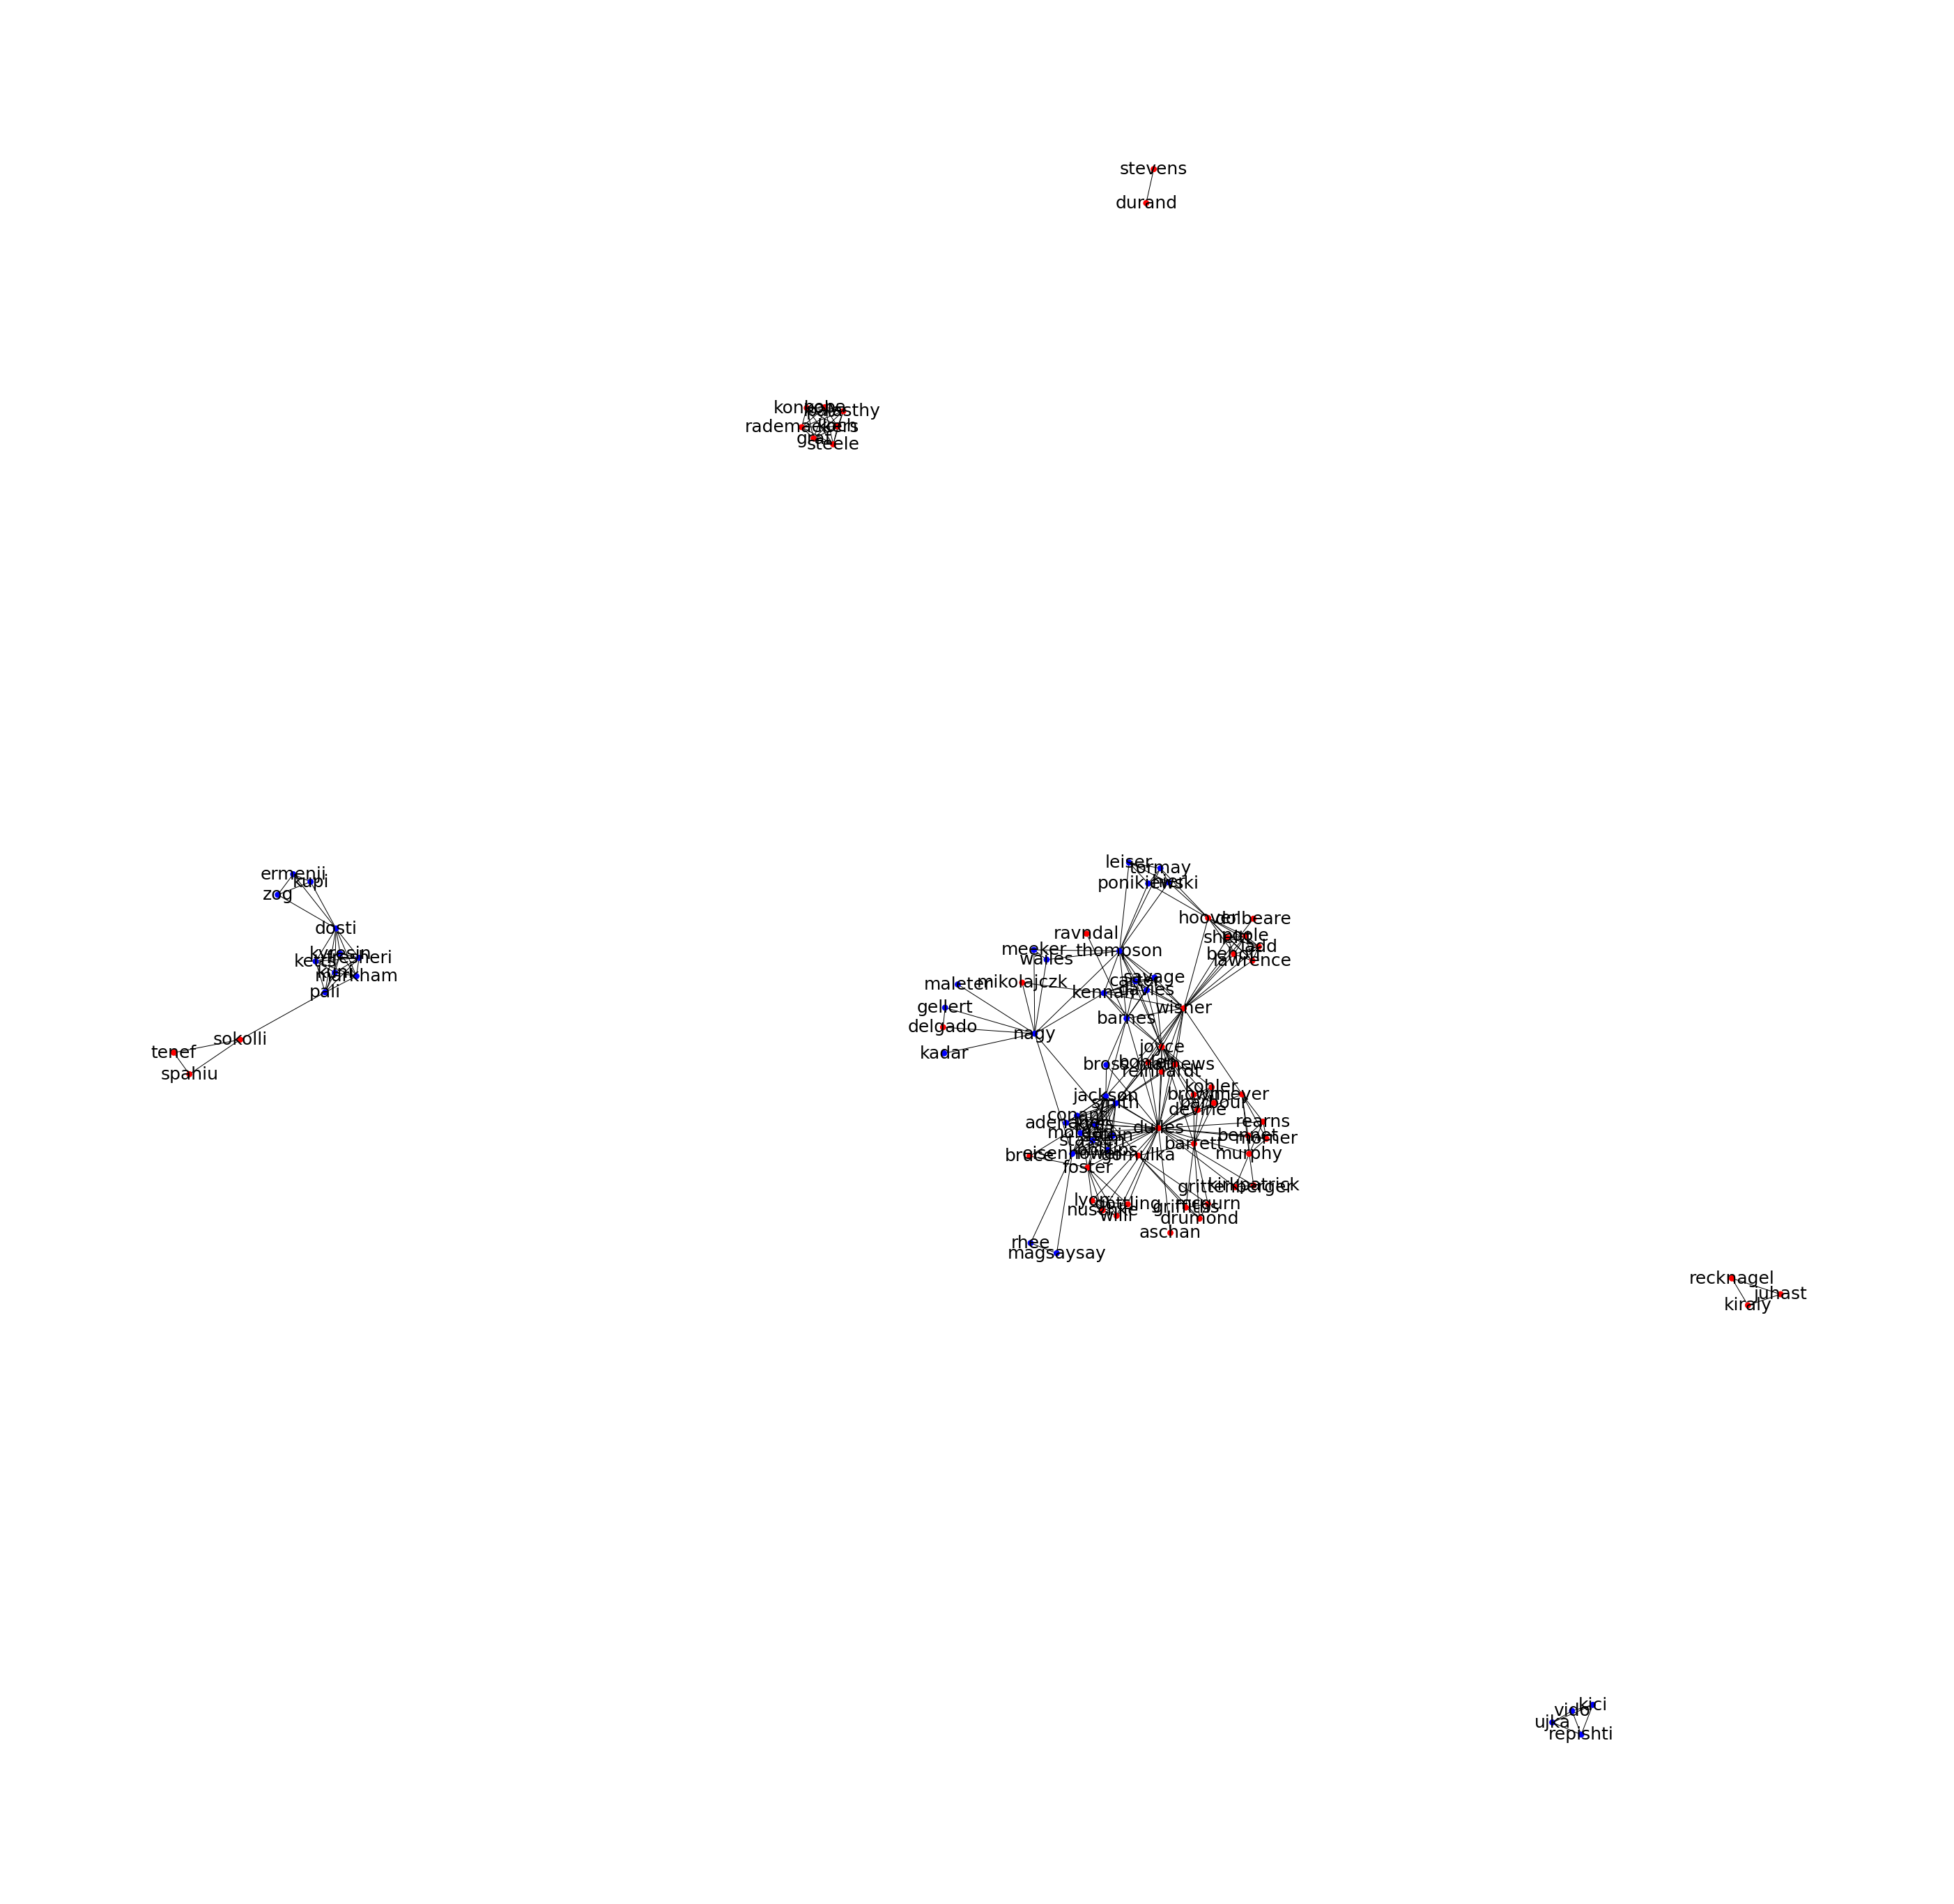

In [113]:
fig, ax = plt.subplots(figsize=(50,50))
print("Degree Corrected SBM")
nx.draw(graph, position, ax=ax, with_labels = True, node_size=60, font_size=25, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in graph])

pl.show()